In [1889]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import category_encoders as ce
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
import random
random.seed(21)

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras import activations
from keras.callbacks import EarlyStopping, ReduceLROnPlateau



# Step 1. Data overview and processing

## 1.1 Reading data from dataset and common overview

In [1890]:
data=pd.read_csv(r'../input/gcar_data.csv')

In [1891]:
data.head(3)

,Unnamed: 0,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,75721,ford,Ford Kuga,black,05/2023,2023,38490,140,190,Automatic,Hybrid,"5,4 l/100 km",124 g/km,100.0,ST-Line Hybrid Adapt.LED+Head-Up-Display Klima
1,80184,hyundai,Hyundai i10,black,09/2018,2018,11555,49,67,Manual,Petrol,"4,6 l/100 km",106 g/km,27782.0,"blue Trend,Viele Extras,Top-Zustand"
2,19864,audi,Audi Q4 e-tron,grey,05/2021,2021,48886,125,170,Automatic,Electric,NaN,0 g/km,4247.0,35 e-tron S line/Matrix/Pano/ACC/SONOS/LM 21


In [1892]:
data.shape

(100000, 15)

In [1893]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                100000 non-null  int64  
 1   brand                     100000 non-null  object 
 2   model                     100000 non-null  object 
 3   color                     99924 non-null   object 
 4   registration_date         99999 non-null   object 
 5   year                      100000 non-null  object 
 6   price_in_euro             100000 non-null  object 
 7   power_kw                  99925 non-null   object 
 8   power_ps                  99928 non-null   object 
 9   transmission_type         100000 non-null  object 
 10  fuel_type                 100000 non-null  object 
 11  fuel_consumption_l_100km  88761 non-null   object 
 12  fuel_consumption_g_km     100000 non-null  object 
 13  mileage_in_km             99932 non-null   fl

In [1894]:
data.isnull().sum()

Unnamed: 0                      0
brand                           0
model                           0
color                          76
registration_date               1
year                            0
price_in_euro                   0
power_kw                       75
power_ps                       72
transmission_type               0
fuel_type                       0
fuel_consumption_l_100km    11239
fuel_consumption_g_km           0
mileage_in_km                  68
offer_description               0
dtype: int64

In [1895]:
data.duplicated().sum()

0

## 1.2 Removing extra data

Deleting unnessesary columns

In [1896]:
def remove_cols(data, cols):
    data.drop(columns=cols, inplace=True)

In [1897]:
# Unnamed - unique ID
# registration_date - not an important car feature, in addition there is creation year
# power_kw - same property as power_ps
# fuel_consumption_g_km - same as fuel_consumption_l_100km
# offer_description - large and unstructured additional info

cols_to_remove = ['Unnamed: 0',
                  'registration_date',
                  'power_kw',
                  'fuel_consumption_g_km',
                  'offer_description']

remove_cols(data, cols_to_remove)

Removing brand from model name

In [1898]:
data['model'] = data['model'].apply(lambda x: ' '.join(x.split()[1:]))

## 1.3 Translating object data to numbers where nessesary

In [1899]:
def col_to_numeric(data, col_name):
    data[col_name] = pd.to_numeric(data[col_name], errors='coerce')  

def consumption_to_numeric(data, col_name):
    data[col_name] = data[col_name].str.replace(' l/100 km', '').str.replace(',', '.')
    data[col_name] = pd.to_numeric(data[col_name], errors='coerce')

In [1900]:
col_to_numeric(data, 'year')
col_to_numeric(data, 'price_in_euro')
col_to_numeric(data, 'power_ps')
consumption_to_numeric(data, 'fuel_consumption_l_100km')

In [1901]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     100000 non-null  object 
 1   model                     100000 non-null  object 
 2   color                     99924 non-null   object 
 3   year                      99947 non-null   float64
 4   price_in_euro             99946 non-null   float64
 5   power_ps                  99907 non-null   float64
 6   transmission_type         100000 non-null  object 
 7   fuel_type                 100000 non-null  object 
 8   fuel_consumption_l_100km  87982 non-null   float64
 9   mileage_in_km             99932 non-null   float64
dtypes: float64(5), object(5)
memory usage: 7.6+ MB


In [1902]:
data.describe()

,year,price_in_euro,power_ps,fuel_consumption_l_100km,mileage_in_km
count,99947.000000,9.994600e+04,99907.000000,87982.000000,9.993200e+04
mean,2016.438522,2.941620e+04,191.074459,6.495231,8.559891e+04
std,7.441014,4.777578e+04,112.837832,21.559934,7.929713e+04
min,1995.000000,1.500000e+02,1.000000,0.000000,0.000000e+00
25%,2014.000000,1.290000e+04,120.000000,5.000000,2.550000e+04
50%,2018.000000,2.049000e+04,159.000000,5.800000,6.800000e+04
75%,2020.000000,3.248000e+04,218.000000,7.000000,1.270000e+05
max,3700.000000,5.890500e+06,2022.000000,2023.000000,3.800000e+06


## 1.4 Removing rows with null values (despite consumption)

In [1903]:
def remove_null_values(data, cols):
    return data.dropna(subset=cols)

In [1904]:
# columns, that may contain null values after converting or form dataset
cols_to_check_null = ['color',
                      'year',
                      'price_in_euro',
                      'power_ps',
                      'mileage_in_km']

data = remove_null_values(data, cols_to_check_null)

## 1.5 Fixing fuel consumption problem

**Problem:** electric cars do not have parameter of fuel consumption

**Possible desicions**
1) Delete fuel consumption parameter ❌
*This parameter significantly affects the formation of the price of the car*
2) Fill nulls with zeroes ❌
*This will make misunderstanding, because electric cars don't need fuel, but it does not mean that it don't need any resources at all*
3) Fill null with median value ❌
*Maybe, but price of the car depends on the consumption anyway*

Let's explore, what factor correlates with consumption

In [1905]:
numeric_cols = ['year',
                  'power_ps',
                  'price_in_euro',
                  'fuel_consumption_l_100km',
                  'mileage_in_km']

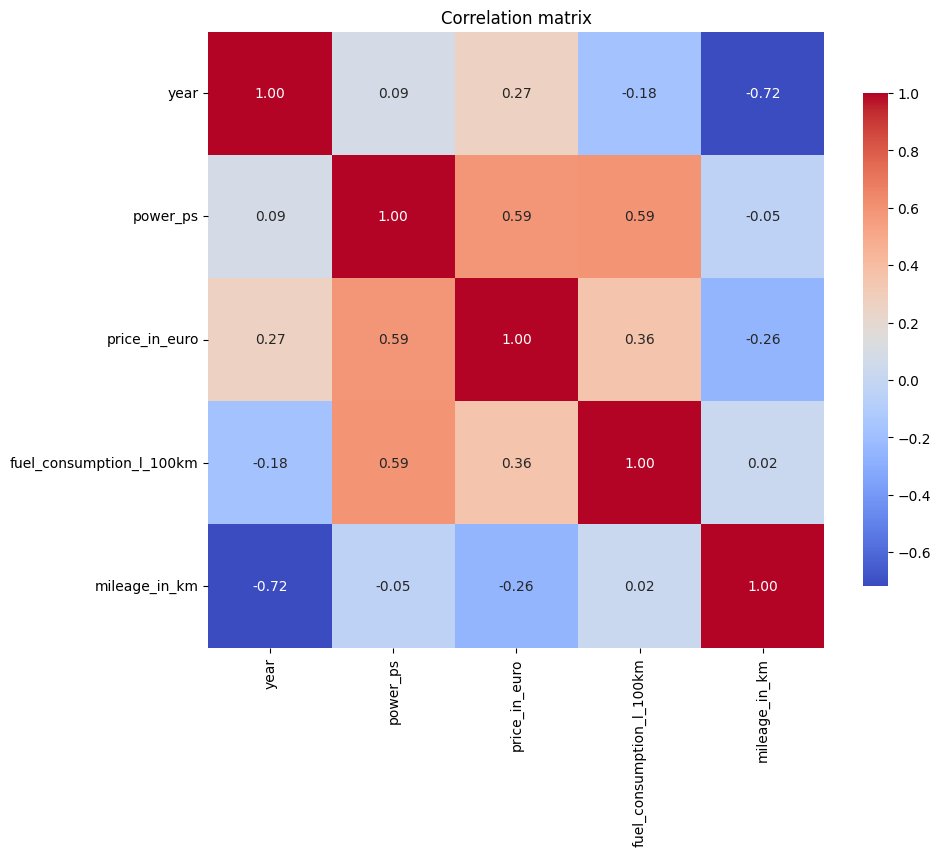

In [1906]:
data_num = data.dropna(subset='fuel_consumption_l_100km')
data_num = data_num[numeric_cols]
correlation_matrix = data_num.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation matrix')
plt.show()

As seen, the highest correlation coefficient for fuel consumption is 0.59 with power_ps

Let's define missing consumption values as median of data clusters based on power

In [1907]:
def medians_of_cluster(data, median_parameter, cluster_parameter, num):
    kmeans = KMeans(n_clusters=num, random_state=42)
    data['cluster'] = kmeans.fit_predict(data[[cluster_parameter]])
    median_values = data.groupby('cluster')[median_parameter].median()
    return median_values, kmeans

In [1908]:
# Data will be clustered by power_ps  (highest correlation coefficient)
median_parameter = 'fuel_consumption_l_100km'
cluster_parameter = 'power_ps'
num = 20

# train data for cluster must contain fuel consumption to count median
cluster_data = data.dropna(subset = 'fuel_consumption_l_100km')
# predict data, what we want to cluster and add median fuel consumption value
fill_data = data[data['fuel_consumption_l_100km'].isna()]

median_values, kmeans = medians_of_cluster(cluster_data, median_parameter, cluster_parameter, num)

# predicting klusters
fill_data['predicted_cluster'] = kmeans.predict(fill_data[[cluster_parameter]])
# filling in missing values
for index, row in fill_data.iterrows():
    fill_data.at[index, median_parameter] = median_values[fill_data.at[index, 'predicted_cluster']]
    
fill_data = fill_data.drop('predicted_cluster', axis=1)
cluster_data = cluster_data.drop('cluster', axis=1)

result_data = pd.concat([cluster_data, fill_data], axis=0)

In [1909]:
result_data.isnull().sum()

brand                       0
model                       0
color                       0
year                        0
price_in_euro               0
power_ps                    0
transmission_type           0
fuel_type                   0
fuel_consumption_l_100km    0
mileage_in_km               0
dtype: int64

## 1.6 Detecting and removing outliers

Calculating outlier bounds

In [1910]:
def get_outlier_bounds(data,col,q_low,q_up):
    Q1=data[col].quantile(q_low)
    Q3=data[col].quantile(q_up)
    iqr=Q3-Q1
    up_limit=Q3+1.5*iqr
    low_limit=Q1-1.5*iqr
    return low_limit,up_limit

In [1911]:
def get_outliers_percent(data, col, q_low, q_up):
    low, up = get_outlier_bounds(data, col,q_low, q_up)
    outliers = [elem for elem in data[col] if (elem > up) or (elem < low)]
    return len(outliers) / data[col].shape[0] * 100

In [1912]:
def rewrite_outliers(data,col, q_low, q_up):
    low,up=get_outlier_bounds(data,col, q_low, q_up)
    data.loc[(data[col]<low),col]=low
    data.loc[(data[col]>up),col]=up
    return data

def remove_outliers(data,col, q_low, q_up):
    low,up=get_outlier_bounds(data,col, q_low, q_up)
    data = data[(data[col] <= up) & (data[col] >= low)]
    return data

In [1913]:
for col in numeric_cols:
    if col == 'price_in_euro':
        # detect outliers and remove them not to deform goal values
        print(col," | outliers percent - ",get_outliers_percent(result_data, col, 0.0, 0.85))
        result_data = remove_outliers(result_data, col,  0.0, 0.85)
    else:
        print(col," | outliers percent - ",get_outliers_percent(result_data, col, 0.25, 0.75))
        result_data = rewrite_outliers(result_data, col, 0.25, 0.75)

year  | outliers percent -  3.352313738070414
power_ps  | outliers percent -  7.639947068730452
price_in_euro  | outliers percent -  2.4981955249017562
fuel_consumption_l_100km  | outliers percent -  5.953115360888341
mileage_in_km  | outliers percent -  1.8764137363767222


# Step 2. Visualizing data

## 2.1 Visualising prices distribution

In [1914]:
def create_hystogram (data, numeric_col, main_title, x_title):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[numeric_col], bins=100, kde=True, stat='probability')
    plt.title(main_title)
    plt.xlabel(x_title)
    plt.ylabel('Frequency')
    plt.show()

def create_set_hystogram(data, cols):
    data[cols].hist(bins=20,figsize=(12,10))
    plt.tight_layout()
    plt.show()

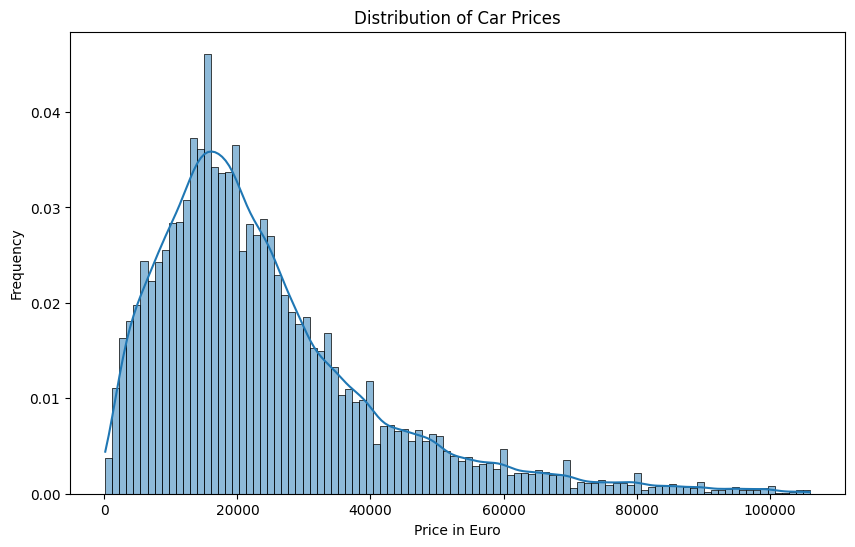

In [1915]:
create_hystogram(result_data, 'price_in_euro', 'Distribution of Car Prices', 'Price in Euro')

## 2.2 Visualising all numeric data distribution

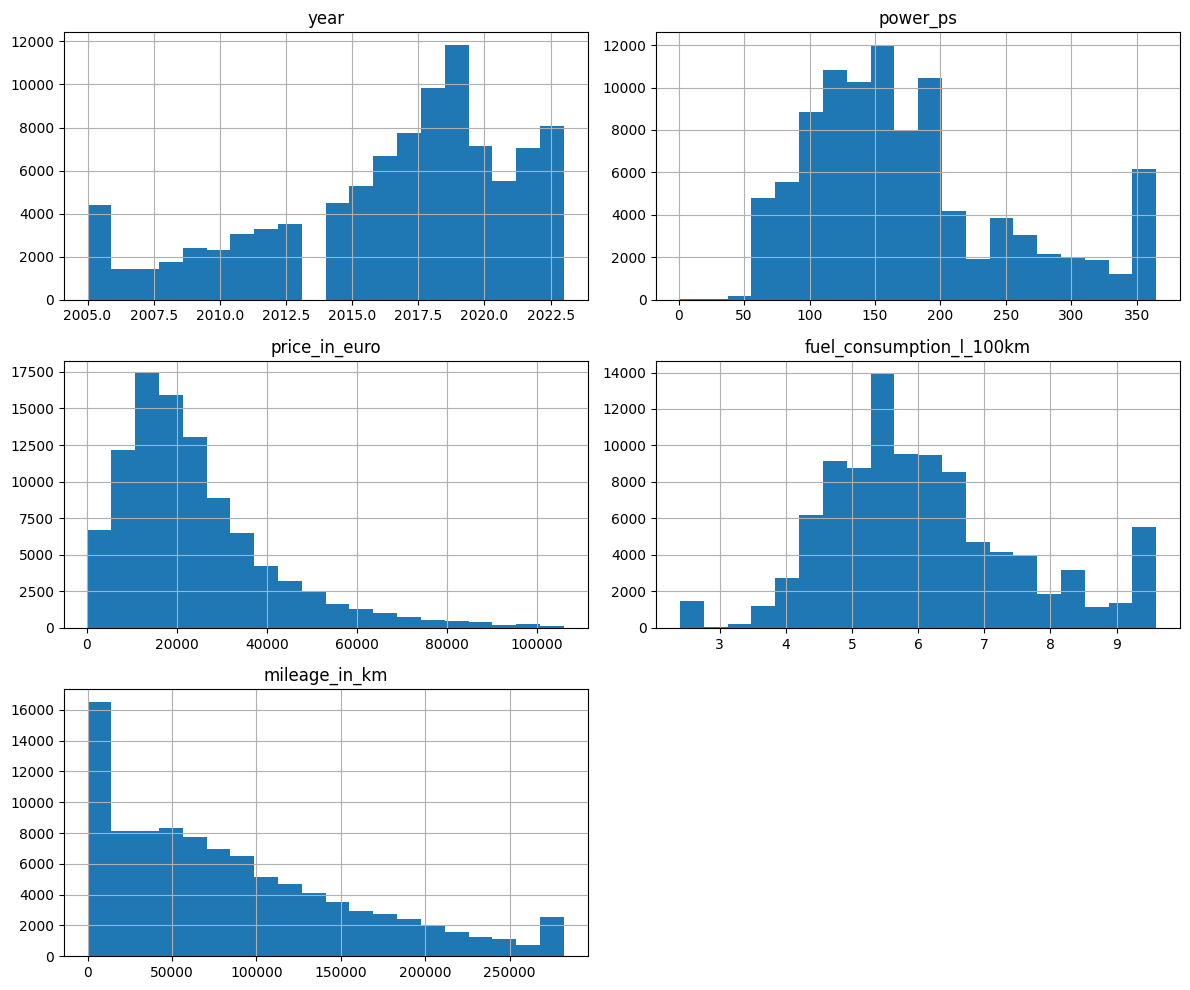

In [1916]:
create_set_hystogram(result_data, numeric_cols)

## 2.3 Visualising categorical clolumns

In [1917]:
categorical_cols = [
'brand',                      
'model',                    
'color',                                      
'transmission_type',         
'fuel_type'
]

In [1918]:
for col in categorical_cols:
    print(col,'unique values: ')
    print(result_data[col].unique())
    print('Total: ', len(result_data[col].unique()))

brand unique values: 
['ford' 'hyundai' 'honda' 'kia' 'dacia' 'bmw' 'citroen' 'audi'
 'alfa-romeo' 'land-rover' 'jaguar' 'fiat' 'mazda' 'isuzu' 'jeep'
 'maserati' 'bentley' 'daihatsu' 'dodge' 'chevrolet' 'daewoo' 'chrysler'
 'cadillac' 'lancia' 'lada' 'infiniti' 'ferrari' 'aston-martin'
 'lamborghini']
Total:  29
model unique values: 
['Kuga' 'i10' 'CR-V' 'Sportage' 'Civic' 'STARIA' 'KONA' 'Fiesta' 'Sandero'
 '520' 'Spacetourer' 'A5' '' 'Romeo 147' 'A4' 'Focus' 'EcoSport' 'Transit'
 'A6' 'Q5' 'X5' 'Rover Range Rover Sport' 'XCeed' 'X1' 'TUCSON' 'F-Pace'
 '730' 'A3' '118' 'Rover Range Rover Evoque' 'A1' 'Optima' '550' '114'
 'S-Max' 'A8' 'M2' 'Q3' '218' '124 Spider' '225' 'CX-7' 'Romeo Stelvio'
 'C-Max' '430' 'i40' 'C5 Aircross' '525' 'D-Max' 'Romeo Giulietta' 'X3'
 'Duster' 'CX-5' 'X6' 'Compass' 'CX-3' '500C' 'Edge' 'Logan' 'Tipo' '500'
 '535' 'Sorento' 'A4 allroad' 'Rover Range Rover' 'Stonic' 'Mondeo' 'M4'
 'Renegade' 'i30' '120' "Ceed / cee'd" 'Z4' 'i20' 'X3 M' 'X4' '530' '6'
 'Q2' 

In [1919]:
def create_categorical_diagram(data, col):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=data, x=col, palette='pastel')
    plt.title('Количество по категориям')
    plt.xlabel('Категория')
    plt.ylabel('Amount')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

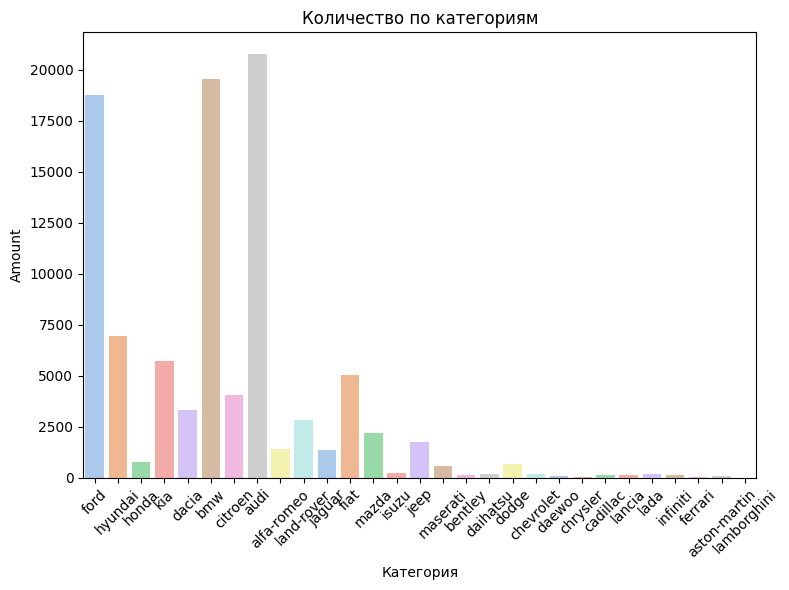

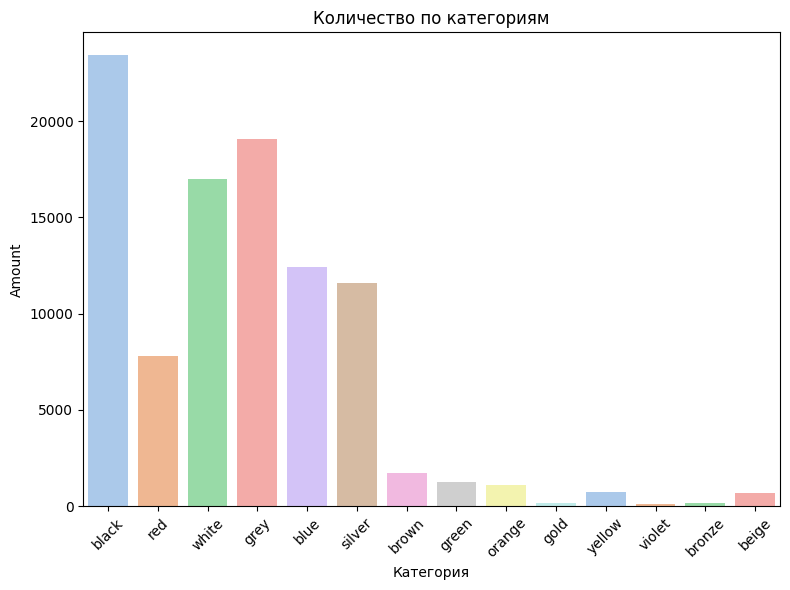

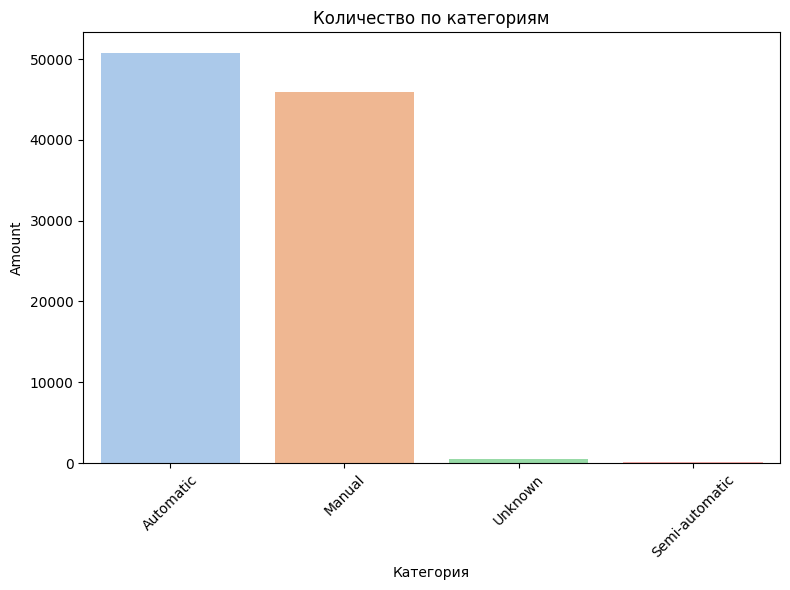

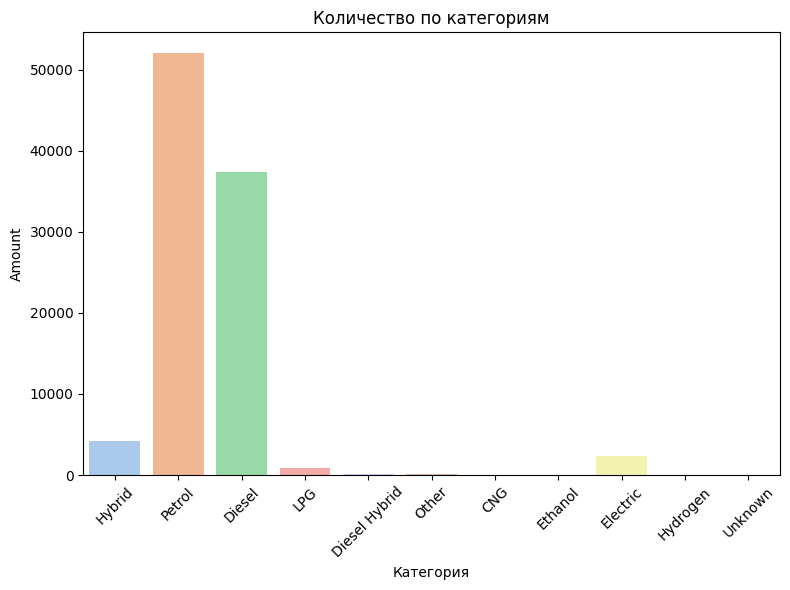

In [1920]:
for col in categorical_cols:
    if col != 'model':
        create_categorical_diagram(result_data, col)

## 2.4 Visualising average price for categorical parameters

In [1921]:
def categorical_price_plot(data, col):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=col, y='price_in_euro', data=data, palette='viridis')
    plt.title('Average Car Prices by categorical column')
    plt.xlabel(col)
    plt.ylabel('Average Price in Euro')
    plt.xticks(rotation=45)  # Поворот меток по оси X для удобства чтения
    plt.show()

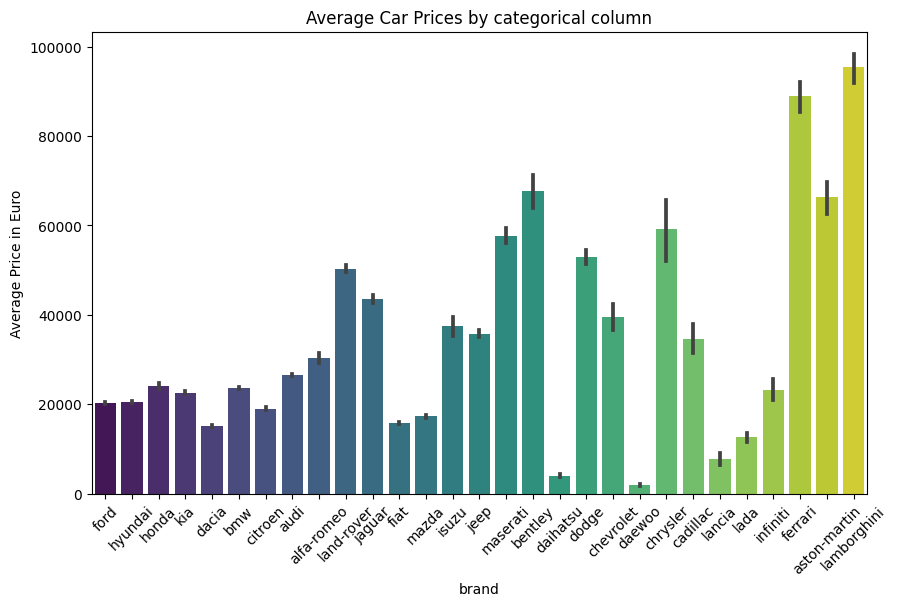

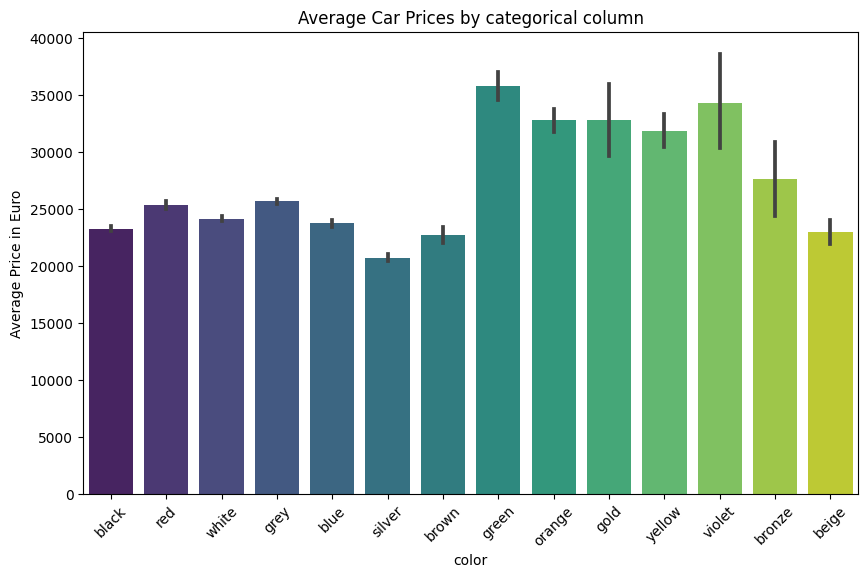

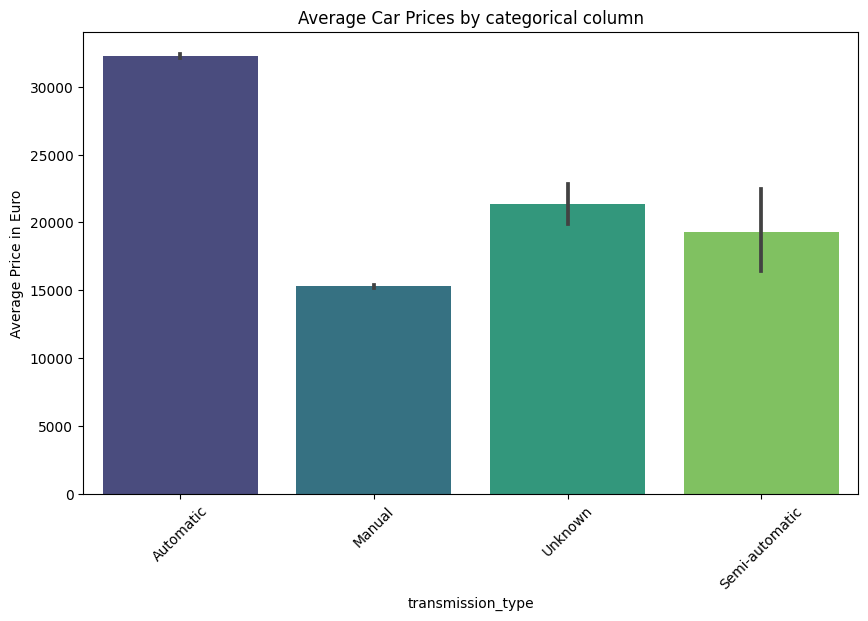

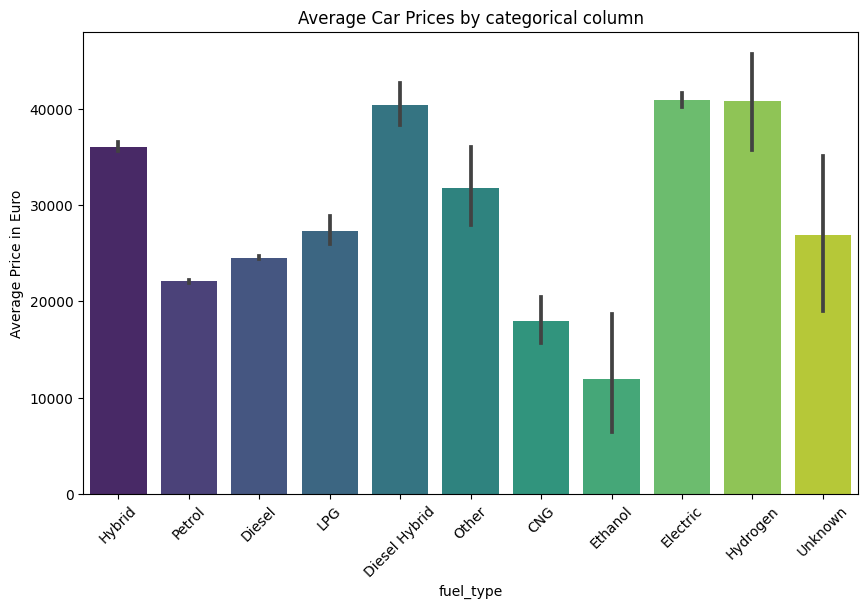

In [1922]:
for col in categorical_cols:
    if col != 'model':
        categorical_price_plot(result_data, col)

# Step 3. Encoding categorical values and split data

In [1923]:
def encode_categorical(data, cols): 
    encoder = ce.BinaryEncoder(cols=cols)
    data_encoded = encoder.fit_transform(data)
    return data_encoded

In [1924]:
result_data = encode_categorical(result_data, categorical_cols)

In [1925]:
x=result_data.drop('price_in_euro',axis=1)
y=result_data['price_in_euro']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=21)

# Step 4. Predicting price

##  4.1 Standard ML models

In [1926]:
R2={}
RMSE = {}
MAE = {}

In [1927]:
# Getting some classic models for regression
model1 = LinearRegression()
model2 = DecisionTreeRegressor(random_state=42)
model3 = RandomForestRegressor(random_state=42)
model4 = GradientBoostingRegressor(random_state=42)

models = {
    'LinearRegression': model1,
    'DecisionTreeRegressor': model2,
    'RandomForestRegressor': model3,
    'GradientBoostingRegressor': model4
}

In [1928]:
def train_model_standard(model, x_train, y_train):
    # model training
    model.fit(x_train,y_train)

def predict(model, x_test):
    # values predicting
    pre = model.predict(x_test)
    return pre

def calculate_metrics(model, x_test, y_test, pre, name, sequential = False):
    # Metrics calculation
    acc = r2_score(y_test, pre)
    rmse = np.sqrt(mean_squared_error(y_test, pre))
    mae = mean_absolute_error(y_test, pre)
    
    R2[name] = acc
    RMSE[name] = rmse
    MAE[name] = mae

    # Output for model
    print(f'Model: {name}')
    if not sequential:
        score = model.score(x_test, y_test)
        print(f'The Score of model is : {score}')
    print(f'R²: {acc}, RMSE: {rmse}, MAE: {mae}')

    # Visualizations with plots
    plt.figure(figsize=(12, 6))

    # Actual vs Predicted values
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, pre)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')

    # Residuals diagram
    plt.subplot(1, 2, 2)
    sns.histplot(y_test - pre, bins=30, kde=True)
    plt.xlabel('Residuals')
    plt.title('Distribution of Residuals')
    plt.tight_layout()
    plt.show()

Model: LinearRegression
The Score of model is : 0.7685177789769981
R²: 0.7685177789769981, RMSE: 8269.52293783665, MAE: 5510.099708568645


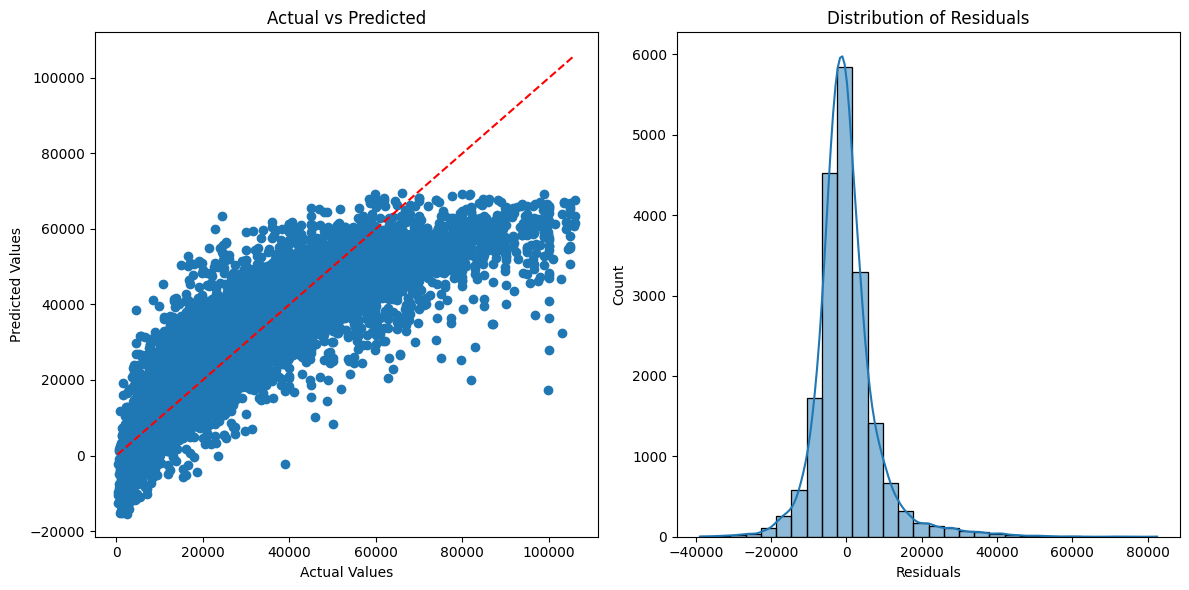

Model: DecisionTreeRegressor
The Score of model is : 0.818404494794283
R²: 0.818404494794283, RMSE: 7324.4359104448, MAE: 3947.508441238424


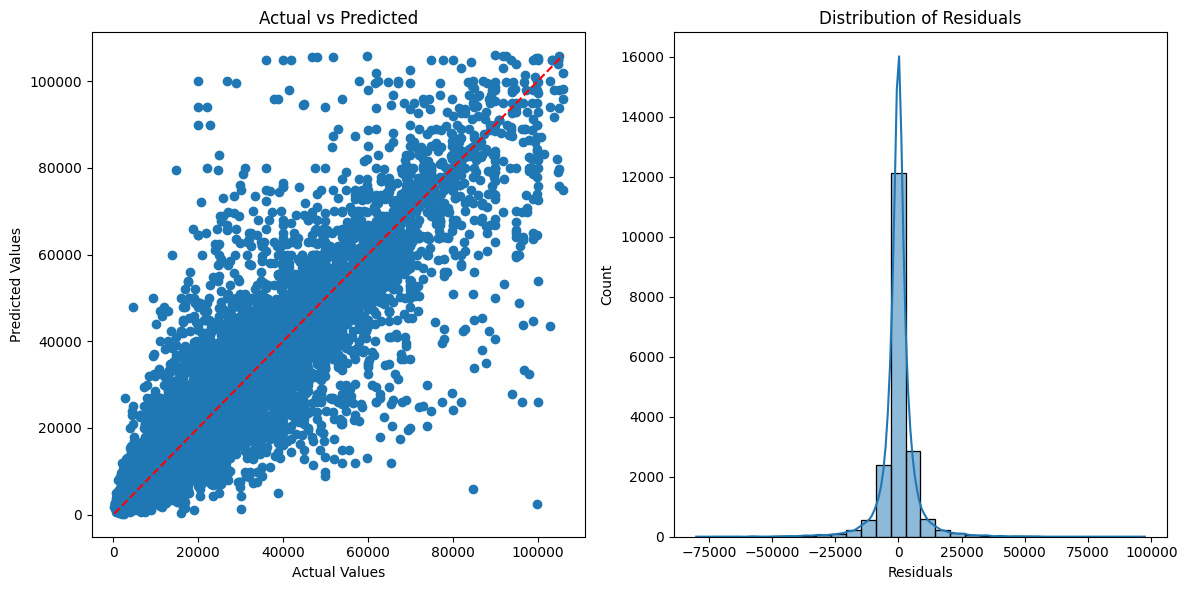

Model: RandomForestRegressor
The Score of model is : 0.906095406906163
R²: 0.906095406906163, RMSE: 5267.021042263601, MAE: 2941.346618594016


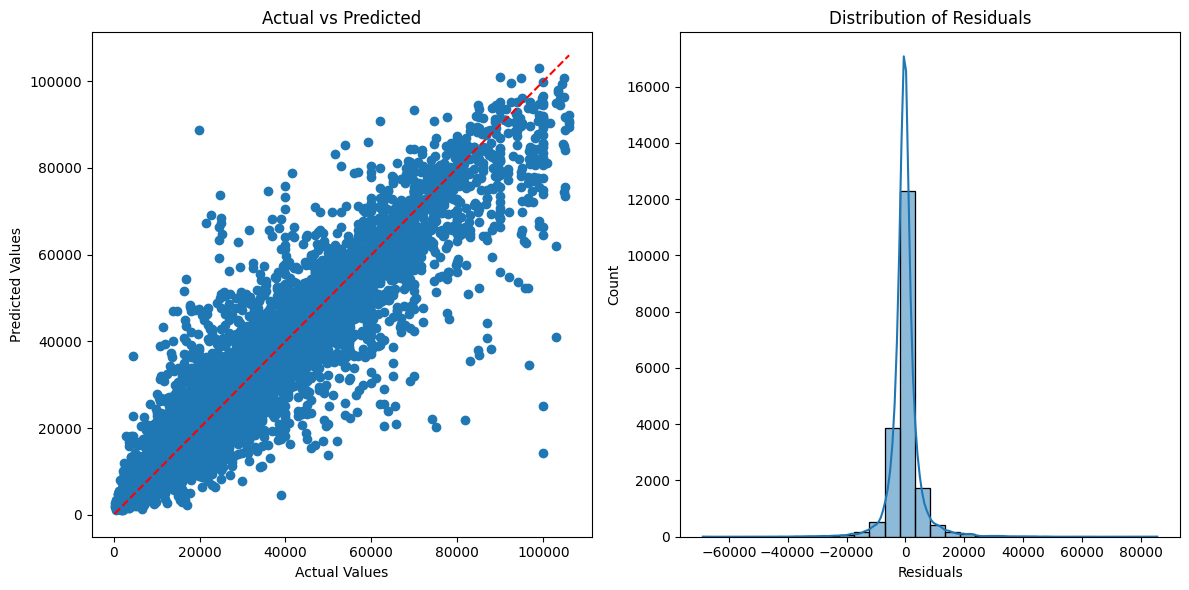

Model: GradientBoostingRegressor
The Score of model is : 0.8573417689306531
R²: 0.8573417689306531, RMSE: 6491.873567261689, MAE: 3925.682431050819


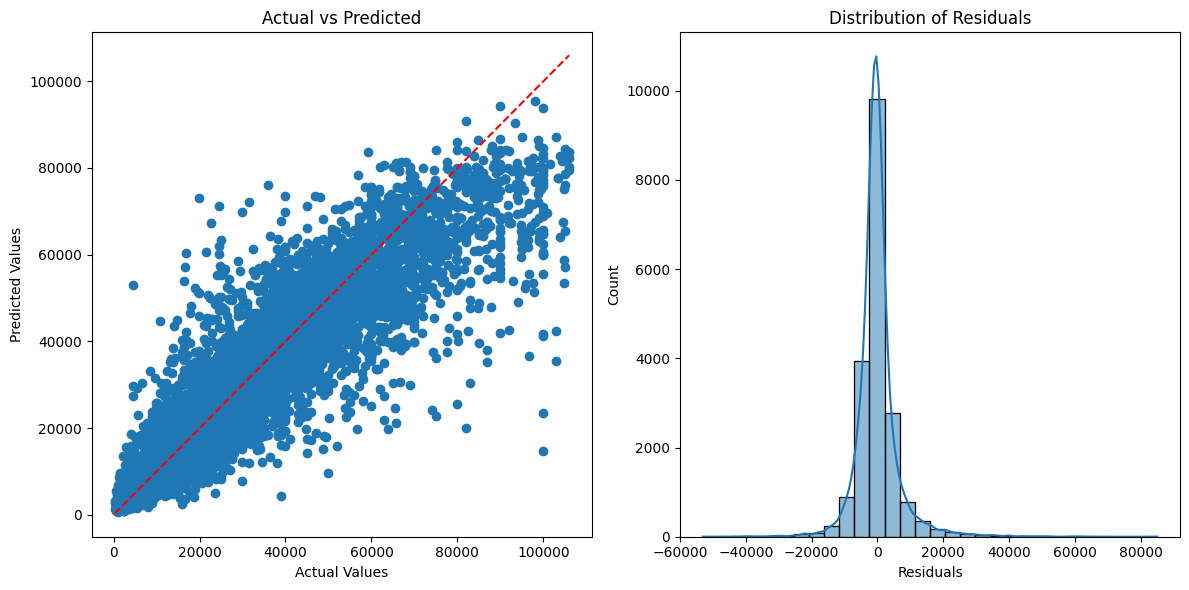

In [1929]:
for name, model in models.items():
    train_model_standard(model, x_train, y_train)
    pre = predict(model, x_test)
    calculate_metrics(model, x_test, y_test, pre, name)

## 4.2 Prediction with DL. Own neural network

In [1930]:
# Scaling values for neural network
def scale_x_values(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [1931]:
# Model with architecture, that represented the best results
def create_dl_model(X_train_cols):
    model = Sequential([
        Dense(512, activation='relu',  input_shape=(X_train_cols,)),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    return model

In [1932]:
# training with best hyperparams
def train_dl_model(model, X_train, X_test, y_train, y_test):
    
    X_train, X_test = scale_x_values(X_train, X_test)
    # splitting data to train and validation parts for best performance
    X_train,X_val,Y_train,Y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=21)
    
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='Adam')
    
    # Define callbacks
    es = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor='val_loss', factor=0.09, patience=15, min_lr=1e-6)
    
    history = model.fit(X_train, Y_train, epochs=200, batch_size=256, validation_data=(X_val, Y_val), callbacks=[es, lr])
    return history

def predict_dl(model,x_train, x_test):
    x_train, x_test = scale_x_values(x_train, x_test)
    pre = model.predict(x_test)
    return pre

In [1933]:
def view_loss_plot(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')  
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Epoch 1/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 868660608.0000 - val_loss: 887331072.0000 - learning_rate: 0.0010
Epoch 2/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 866052352.0000 - val_loss: 880047680.0000 - learning_rate: 0.0010
Epoch 3/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 856566080.0000 - val_loss: 860564096.0000 - learning_rate: 0.0010
Epoch 4/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 835958976.0000 - val_loss: 825900032.0000 - learning_rate: 0.0010
Epoch 5/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 801455232.0000 - val_loss: 773340864.0000 - learning_rate: 0.0010
Epoch 6/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 752215040.0000 - val_loss: 715833152.0000 - learning_rate: 0.0010
Epoch 7/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 688716224.0000 - val_loss: 627633728.0000 - learning_rate: 0.0010
Epoch 8/200
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 613384896.0000 - val_loss: 547871232.0000 - learni

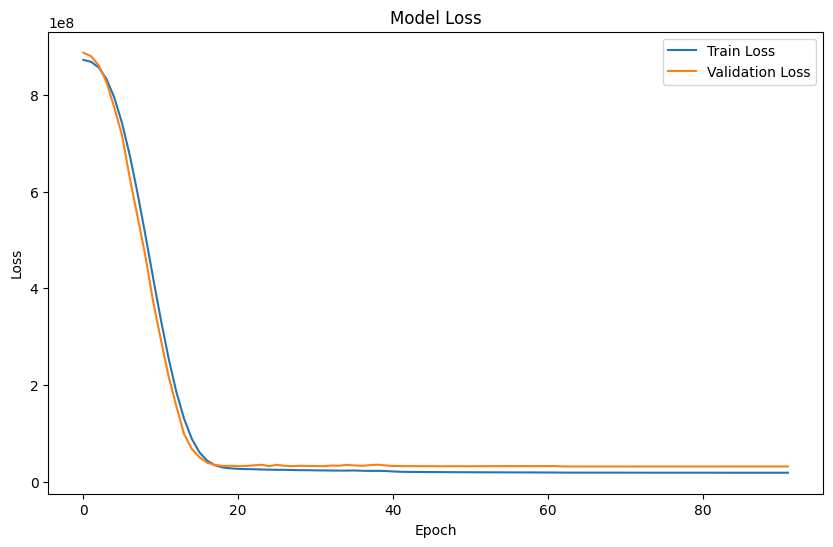

In [1934]:
# Creating my model
my_model = create_dl_model(x_train.shape[1])
# Training
hist = train_dl_model(my_model, x_train, x_test, y_train, y_test)
# View train info about loss
view_loss_plot(hist)

608/608 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model: DL Regression Model
R²: 0.9024541573764011, RMSE: 5368.167002092625, MAE: 3029.5325413617043


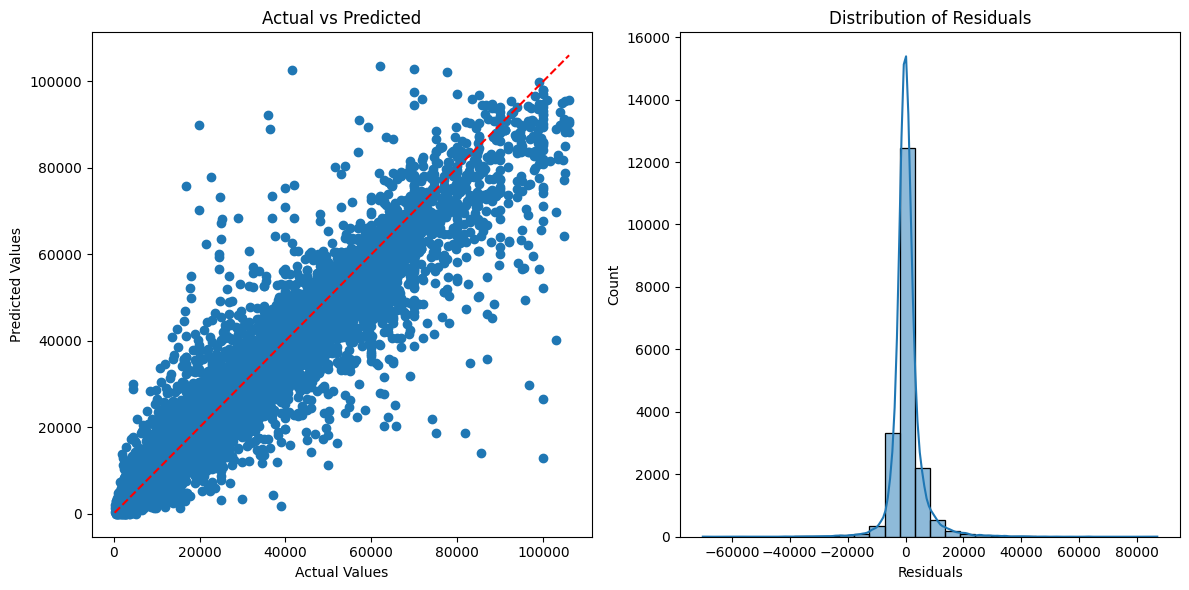

In [1935]:
# calculating metrics for test data prediction
pre = predict_dl(my_model, x_train, x_test)
pre = pre.flatten() 
calculate_metrics(my_model, x_test, y_test, pre, 'DL Regression Model', True)

## 4.3 Compare metrics with standard methods

In [1936]:
def make_metric_plot(metric_data, name):
    names = list(metric_data.keys())
    values = list(metric_data.values())
    
    plt.figure(figsize=(10, 5))
    plt.bar(names, values, color='skyblue')
    plt.title(name)
    plt.xlabel('Models')
    plt.ylabel(name)
    plt.xticks(rotation=45)
    bars = plt.bar(names, values, color='skyblue')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')
    plt.show()

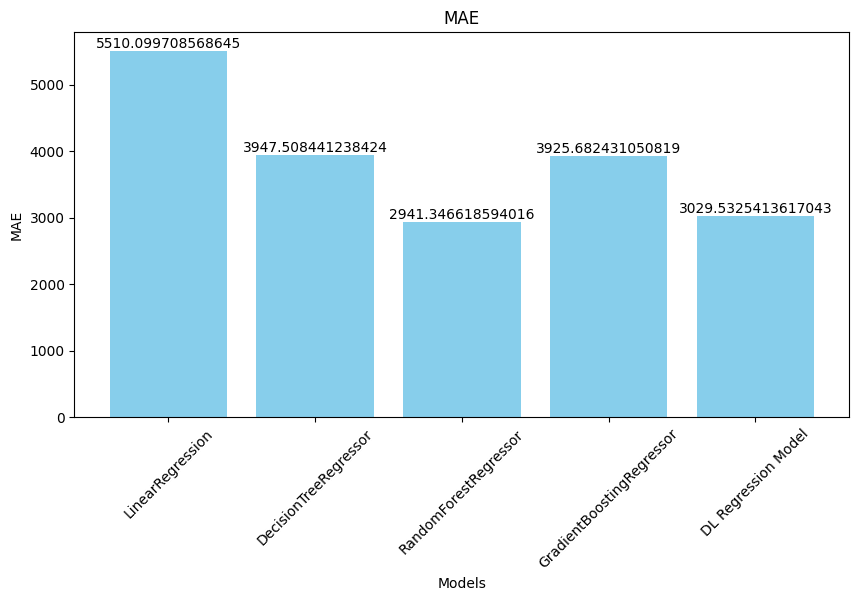

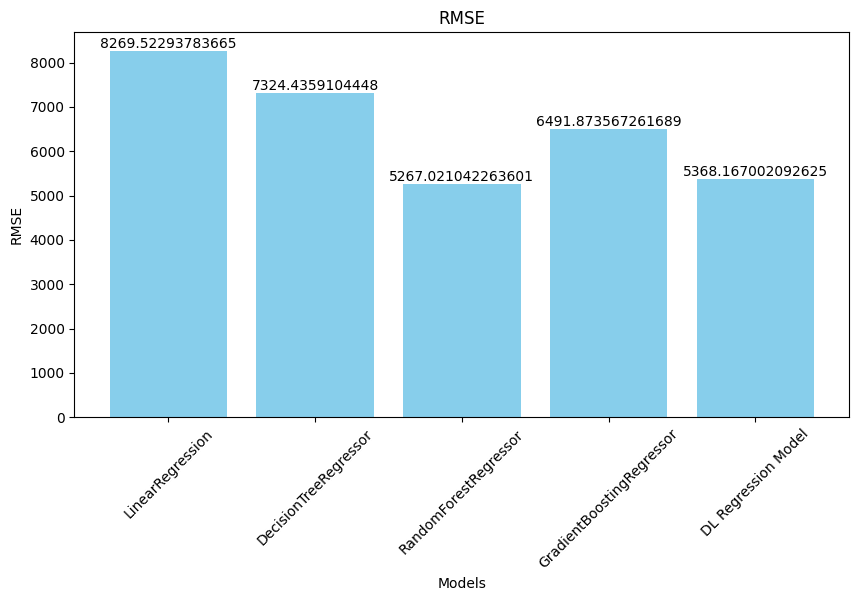

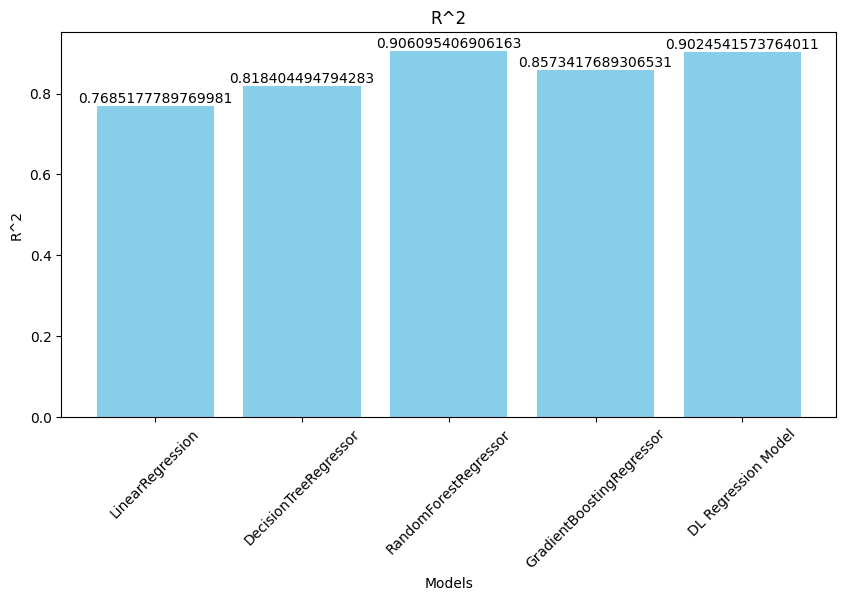

In [1937]:
make_metric_plot(MAE, 'MAE')
make_metric_plot(RMSE, 'RMSE')
make_metric_plot(R2, 'R^2')

As seen, DL Regression performs slightly below Random Forest Regression. This indicates that DL models can be just as effective as standard ones for prediction, making them a suitable choice for this task. The observed difference can likely be attributed to random choise, further supporting the viability of DL models.